## Solution to Assignment 4 (Approach 2)

In [ ]:
import pymc as pm
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = datasets.load_iris()

X = iris.data[:,:2]
y = iris.target

species_idx = 0
y_binary = (y==species_idx).astype(np.float64)

print(X.shape,y.shape)

(150, 2) (150,)


Text(0.5, 1.0, 'The Data')

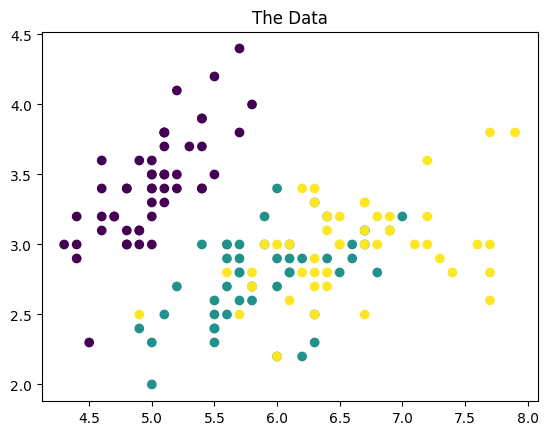

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.title('The Data')

In [ ]:
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_normalized = (X - X_mean) / X_std

### Question 1

In [ ]:
with pm.Model() as model_reg:
  l = pm.Gamma('l',2,0.5)
  eta = pm.HalfNormal('eta',sigma=1.0)
  cov = eta ** 2 * pm.gp.cov.ExpQuad(2,ls=l)
  gp = pm.gp.Marginal(cov_func=cov)
  eps = pm.HalfNormal('eps',1.0)
  gp = pm.gp.Latent(cov_func=cov)
  f = gp.prior(name="f", X=X_normalized, dims="idx")
  p = pm.Deterministic(name="p", var=pm.math.invlogit(f), dims="idx")
  likelihood = pm.Bernoulli(name="likelihood", p=p, dims="idx", observed=y_binary)

  trace_reg = pm.sample(1000,return_inferencedata=True,target_accept=0.95,cores=1)

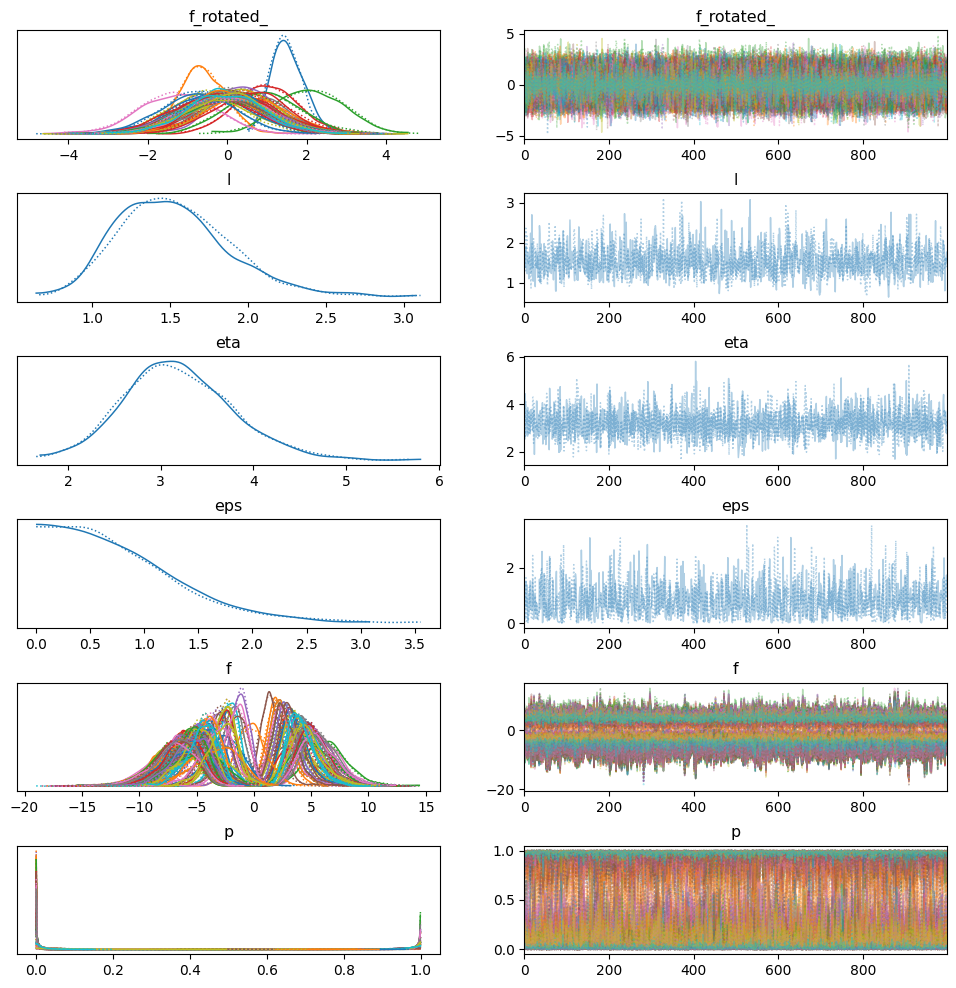

In [ ]:
import arviz as az
az.plot_trace(trace_reg,compact=True)
plt.subplots_adjust(hspace=0.5)

### Question 2

In [ ]:
x_min, x_max = X_normalized[:, 0].min() - 1, X_normalized[:, 0].max() + 1
y_min, y_max = X_normalized[:, 1].min() - 1, X_normalized[:, 1].max() + 1
h = 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_new = np.c_[xx.ravel(),yy.ravel()]
print(X_new.shape)

(806, 2)


In [ ]:
with model_reg:
  f_pred = gp.conditional("f_pred",X_new)
  p_pred = pm.Deterministic(name="p_pred", var=pm.math.invlogit(f_pred))
  likelihood_pred = pm.Bernoulli(name="likelihood_pred", p=p_pred)
  pred_samples = pm.sample_posterior_predictive(trace=trace_reg, var_names=["f_pred", "p_pred", "likelihood_pred"])
  #f_pred = gp.conditional("f_pred",X_new)
  #pred_samples = pm.sample_posterior_predictive(trace_reg,var_names=["f_pred"])

In [ ]:
pred_samples.posterior_predictive

<xarray.Dataset>
Dimensions:                (chain: 2, draw: 1000, f_pred_dim_2: 806,
                            p_pred_dim_2: 806, likelihood_pred_dim_2: 806)
Coordinates:
  * chain                  (chain) int64 0 1
  * draw                   (draw) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * f_pred_dim_2           (f_pred_dim_2) int64 0 1 2 3 4 ... 802 803 804 805
  * p_pred_dim_2           (p_pred_dim_2) int64 0 1 2 3 4 ... 802 803 804 805
  * likelihood_pred_dim_2  (likelihood_pred_dim_2) int64 0 1 2 3 ... 803 804 805
Data variables:
    f_pred                 (chain, draw, f_pred_dim_2) float64 -1.948 ... -1.775
    p_pred                 (chain, draw, p_pred_dim_2) float64 0.1248 ... 0.145
    likelihood_pred        (chain, draw, likelihood_pred_dim_2) int64 0 1 ... 0
Attributes:
    created_at:                 2024-04-06T01:16:58.506766
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4

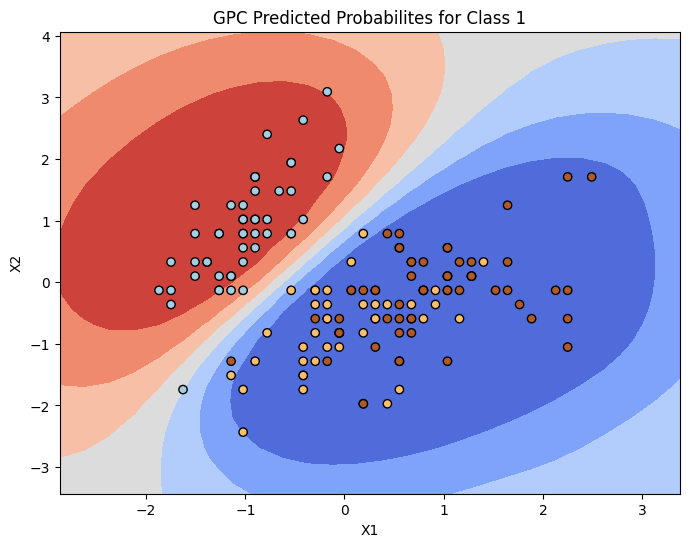

In [ ]:
# Plot contour plot
plt.figure(figsize=(8, 6))
#s = 1.0 / (1.0 + np.exp(-pred_samples.posterior_predictive["f_pred"].values.mean(0).mean(0)))
s = pred_samples.posterior_predictive['p_pred'].values.mean(0).mean(0)
plt.contourf(xx, yy,s.reshape(xx.shape),cmap='coolwarm')
plt.scatter(X_normalized[:,0],X_normalized[:,1],c=y,marker='o',edgecolor='k',cmap=plt.cm.Paired)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("GPC Predicted Probabilites for Class 1")
plt.show()

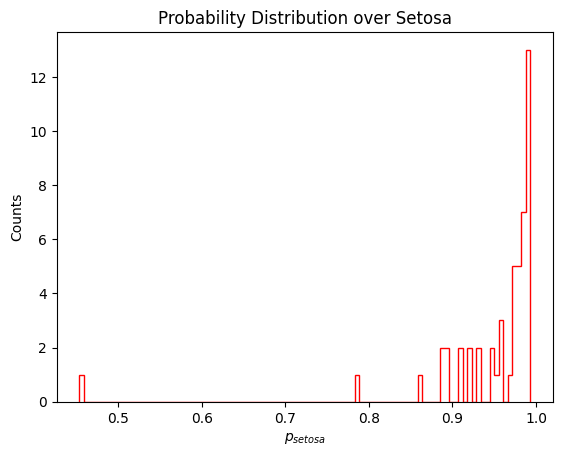

Number of Setosa with p > 0.5:  49 / 50


In [ ]:
p_setosa = trace_reg.posterior['p'].values.mean(0).mean(0)[np.where(y_binary == 1.0)[0]]
plt.hist(p_setosa,bins=100,histtype='step',color='red')
plt.title('Probability Distribution over Setosa')
plt.xlabel(r'$p_{setosa}$')
plt.ylabel('Counts')
plt.show()
print("Number of Setosa with p > 0.5: ",len(np.where(p_setosa > 0.5)[0]),"/",len(p_setosa))

### Question 4

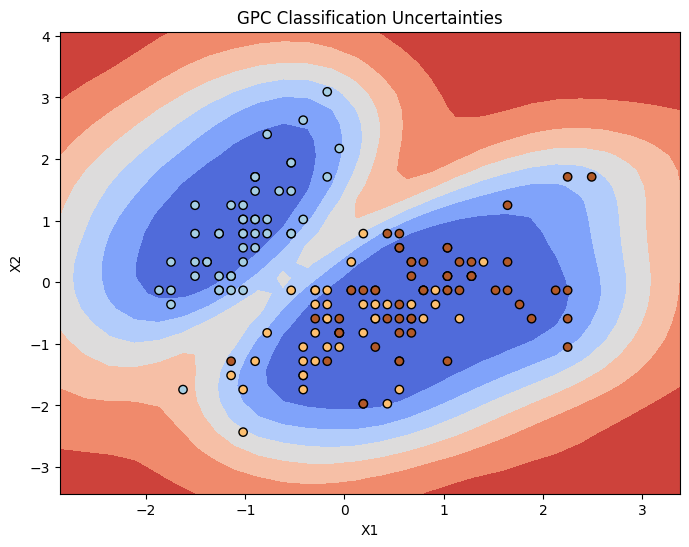

In [ ]:
# Plot contour plot
plt.figure(figsize=(8, 6))
#s = 1.0 / (1.0 + np.exp(-pred_samples.posterior_predictive["f_pred"].values.mean(0).mean(0)))
s = pred_samples.posterior_predictive['p_pred'].values.mean(0).std(0)
plt.contourf(xx, yy,s.reshape(xx.shape),cmap='coolwarm')
plt.scatter(X_normalized[:,0],X_normalized[:,1],c=y,marker='o',edgecolor='k',cmap=plt.cm.Paired)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("GPC Classification Uncertainties")
plt.show()

### Question 5

Using [P - 0.5] > 3 $\sigma(p)$ we find that all points are retained except one. This point lies in the lower left hand corner of all plots (both above and below). From the contours plots it can be seen this point is missed by our GPC.

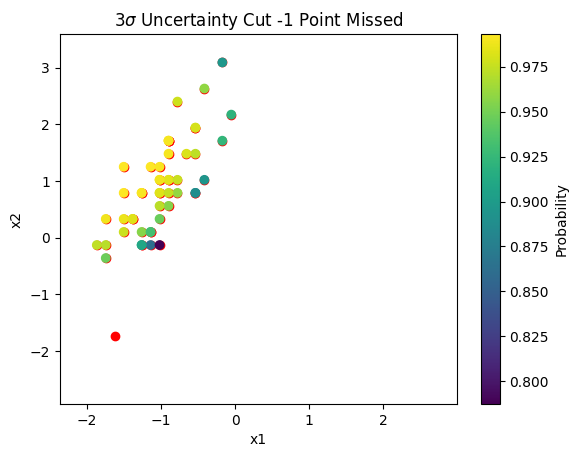

In [ ]:
original_p = trace_reg.posterior['p'].values.mean(0).mean(0)
uncertainty_p = trace_reg.posterior['p'].values.mean(0).std(0)


p_sig_test = original_p - 0.5
resulting_setosa = np.where(p_sig_test > 3*uncertainty_p)[0]
resulting_setosa_p = original_p[resulting_setosa]
true_idx = np.where(y_binary == 1.)[0]


plt.scatter(X_normalized[true_idx,0],X_normalized[true_idx,1],c='red',alpha=1.0)
plt.scatter(X_normalized[resulting_setosa,0],X_normalized[resulting_setosa,1],c=resulting_setosa_p)
plt.colorbar(label='Probability')
plt.xlim(X_normalized[:,0].min() - 0.5,X_normalized[:,0].max()  + 0.5 )
plt.ylim(X_normalized[:,1].min()-0.5 ,X_normalized[:,1].max() + 0.5)
plt.xlabel("x1")
plt.ylabel('x2')
plt.title(r'$3\sigma$ Uncertainty Cut -1 Point Missed')
plt.show()

### Overall classification performance:

Note this is indifferent under the uncertainty cuts.

In [ ]:
predictions_ = (original_p > 0.5).astype('int')
print("Accuracy: ", np.sum(predictions_ == y_binary) / len(y_binary))

Accuracy:  0.9933333333333333


### Bonus Question 1

Yes entirely. From the countour plots we can see the probability, and also confidence of the model increases as we move towards a 'central' mass, i.e., the centroid of class 0 or 1 in the feature space. The uncertainty of the model increases in low density regions which is desirable.

### Bonus Question 2

I actually opted for a more 'optimal' configuration by default in the model construction by using directly a GP with latent variable. When utilizing the intial model I noticed that the probabilities had a lower bound of ~ 0.5, i.e. the model was not really learning the distribution of the other class (0). This is directly related to the intitial discretization of the space, i.e. as we move away from 0,1 to -10,10 the performance of the marginal improves.

It is true the results depend on:

* kernel function
* GP output discretization
* Scaling factor on sigmoid

The kernel function we choose will define how we model the covariance terms and is therefore directly tied to the performance of the model. The discretization is very important as mentioned prior. Scaling factor on the sigmoid will just make the distributions of the class more multimodal, i.e., two distributions centered around p = 0.5.

What did I learn?

These are useful techniques and offer a lot of residual information apart from just a classification label in this case. They offer uncertainty, but also information on uncertainty due to low density regions. I am considering two cases where uncertainty should be high:

* on the boundary of two classes
* low density regions

I am not aware of other methods that provide both.

### Bonus Question 3

Sure. Lets use one from my old assignment and see what we get.

In [ ]:
with pm.Model() as lgr:
    alpha = pm.Normal('alpha',mu=0,sigma=1)
    betas = pm.Normal('betas',mu=0,sigma=1,shape=X_normalized.shape[1])
    mu = alpha + pm.math.dot(X_normalized,betas)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    lkd = pm.Bernoulli('lkd',p=theta,observed=y_binary)

    lr_posterior = pm.sample(1000,tune=2000,return_inferencedata=True,target_accept=0.95)

In [ ]:
plr = lr_posterior.posterior['theta'].values.mean(0).mean(0)
pred_lr = (plr > 0.5).astype('int')
print("Accuracy from BLR: ", np.sum(pred_lr == y_binary) / len(y_binary))

Accuracy from BLR:  0.9933333333333333


So we see the performance of the models is identical. This is to be expected given the distribution of the features. There exists a very easily identifiable decision boundary for the BLR to identify. However, in cases where the decision boundary is highly non-linear, a GPC would outperform. It is similar in operation to other classification methods that use radial basis functions.